# Example query  - how to run a query and get the df

In [1]:
import common_functions_cache as c
import pickle

In [2]:
print(c.__doc__)

Version of common functions with more caching, also using new sqlite db schema (LTCC_cache). Functions for querying abstracts on ePMC, saving results in sqlite db and displaying results in dataframe.
More checks in this version to avoid duplicate retrieval of information from web services. 
Functions available:
create_db(db_name)
pop_chembl_pmids(db_name) -- this populates the chembl_pmids table with pmids from a specific chembl_version.
def define_synonym_queries(term_dict_1, term_dict_2 = None, term_dict_3 = None)
get_hit_profile(query_list)
get_pmids(query, db_name) -- query is string
get_article_data(query_id, db_name) -- query is string
get_pmids_and_article_data(query, db_name) -- query is string
get_availabilities(query_id, db_name)
get_scores(query_id, db_name)
set_chembl_values(query_id, db_name)
get_df(query_id_list, db_name, sql_condition=None)
separate_column_df(query_id)
colour_terms(df, markup_list)
plot_scores(query_id_list, db_name)



## 1. Create sqlite db and populate chembl_pmids table from ChEMBL.
This only needs to be done once. Use create_db and pop_chembl_ids functions.

In [3]:
print(c.create_db.__doc__)

Create the SQLite database in the current directory.
    kwargs: db_name -- name of the new SQLite db you are creating


In [4]:
print(c.pop_chembl_pmids.__doc__)

Get all pubmed ids from ChEMBL_20 and populate the chembl_pmids table in the SQLite db with those pmids. Needs a file with login details to ChEMBL database.
    kwargs: db_name -- name of the SQLite db of which the chembl_pmids table should be updated


## 2. Define your query

We want to get from a set of terms to df with the resulting abstracts with hyperlinks and interesting terms highlighted.
Two preconditions:
* You already created an sqlite db and it is in the working directory.
* You have a file in your /homes folder with login details for chembl, you need to specify the location of this file in the pop_chembl_pmids function in the common_functions file.

In [5]:
print(c.define_synonym_queries.__doc__)

Submit one, two or three dicts with synonyms/alternative terms to be used. 
    If there are no synonyms bu just one term, just include the primary term as one item in the list that is that value of the dict.
    For each dict the terms in the dict will be joined by OR. The three different dicts will be joined by AND in the query.
    Returns a list of queries. It is possible to have only one item in a dictionary, if you only want to do one query.
    Otherwise include the independent items to look for as different items in the dictionary.
    
    kwargs: term_dict_1 -- dict of terms (in list in value of dict) to be connected with OR in the query
            term_dict_2 -- additional terms to be included in the same query (default = None)
            term_dict_3 -- even more terms to be included in the same query (default = None)
    


#### With terms

In [6]:
ca_terms = {'terms': ['calcium channel'
                                , 'L-type calcium channel', 'LTCC']}

chemistry_terms = {'terms': ['QSAR', 'structure-activity relationship'
                            ]}


In [7]:
ca_query_1 = c.define_synonym_queries(term_dict_1=ca_terms, term_dict_2=chemistry_terms)

In [8]:
ca_query_1[0]

'(ABSTRACT:"calcium channel" OR ABSTRACT:"L-type calcium channel" OR ABSTRACT:"LTCC") AND (ABSTRACT:"QSAR" OR ABSTRACT:"structure-activity relationship")'

In [9]:
print(c.get_hit_profile.__doc__)

For each query in query_list print profile hits. This uses the profile module of ePMC webservices. Will print results to console.
    kwargs: query_list -- list of queries (strings), e.g from define_synonym_queries function.


#### With pmid_ids

In [10]:
my_pmid_list = [14528490, 10575370, 21975802]

In [11]:
def make_query_string(list_of_pmids):
    query_string = ''

    for pmid in list_of_pmids:
        query_string = query_string + 'ext_id:"' + str(pmid) + '" OR '

    query_string = query_string.strip('OR ^')
    final_string = '(' + query_string + ')'
    return final_string


In [12]:
pmid_string = make_query_string(my_pmid_list)
pmid_string

'(ext_id:"14528490" OR ext_id:"10575370" OR ext_id:"21975802")'

In [13]:
my_pmid_string = '(' + pmid_string + ') AND '

### Check the hitcount

In [14]:
c.get_hit_profile([ca_query_1[0]])

(ABSTRACT:"calcium channel" OR ABSTRACT:"L-type calcium channel" OR ABSTRACT:"LTCC") AND (ABSTRACT:"QSAR" OR ABSTRACT:"structure-activity relationship")
{'full text': '11', 'all': 115}

total number of hits = 115


In [15]:
c.get_hit_profile([pmid_string])

(ext_id:"14528490" OR ext_id:"10575370" OR ext_id:"21975802")
{'full text': '0', 'all': 3}

total number of hits = 3


## 3. Get the information from ePMC and update db

#### If you just want to get the pmids for overlap checking, without getting the rest of the info, do this:

In [16]:
print(c.get_pmids.__doc__)

For given query (string) get results in forms of idlist from ePMC. Record the query and date in the queries table. Save pmids associated with the query in the result_ids table.
    It will be better to use the get_pmids_and_article data function, but if only getting the pmids is required for quick overlap checking, for example, then use this function.
    Return the query_id assigned to the query in the queries table, can then be used in subsequent functions.
    kwargs: query -- should be string
            db_name
    


In [17]:
# This returns the newly created query_id for that query
my_query_id1 = c.get_pmids(ca_query_1[0], 'cluster_db')
my_query_id1

6

In [18]:
print(c.get_article_data.__doc__)

If already perfomed the get_pmids function for a query, now go in more detail and get the article data associated with the pmids form ePMC.
    Checks whether the pmid already exists in the article_data table and if so, skips that one and does not extract article data from ePMC.
    Returns None. 
    kwargs: query_id -- (obtained from get_pmids function)
            db_name


In [19]:
c.get_article_data(query_id = my_query_id1, db_name = 'cluster_db')

#### Alternatively, you can do both at once:

In [20]:
print(c.get_pmids_and_article_data.__doc__)

Does same as get_pmids and get_article_data functions but in one step, which I think is faster than doing both separately. Uses the core resulttype from ePMC search module.
    Does not exclude articles that are in chembl because that field is set later.
    Return the query_id assigned to the query in the queries table, can then be used in subsequent functions.
    kwargs:
            query -- string
            db_name -- name of SQLite db
    
    


In [21]:
my_query_id2 = c.get_pmids_and_article_data(pmid_string, db_name = 'cluster_db')
my_query_id2

7

## 4. Get further info on full text availability, chembl-likeness score and fill out in_chembl field in article_data table

In [22]:
print(c.get_availabilities.__doc__)

Want to check access to paper via campus subscriptions for those without 'F' or 'OA' in the availability_codes OR those without any availability codes, of a given query. 
    Check whether the SFX resolver has link to Full Text available, if so, save link in campus_links field of the article_links table, else, save link to 'request document' form in request_access field in article_links table.
    Excludes articles already in ChEMBL. Also skips pubmed ids which have article data already retrieved.
    kwargs: query_id -- query_id from queries table in queries_db
            db_name -- name of SQLite database


In [23]:
c.get_availabilities(query_id = my_query_id1, db_name = 'cluster_db')
c.get_availabilities(query_id = my_query_id2, db_name = 'cluster_db')

### Also populate the in_chembl field for newly added pmids

In [24]:
print(c.get_scores.__doc__)

For given query_id rank corresponding titles and abstracts using ChEMBL HeCaToS webservice (ChEMBL-likeness score). 
    Save in scores table. Excludes any pmids for which there is already a score in the scores table.
    If no score could be retrieved, is saved in error table together with pmid and query_id
    kwargs: query_id -- query_id from queries table, db_name


In [25]:
c.get_scores(query_id = my_query_id1, db_name = 'cluster_db')

In [26]:
c.get_scores(query_id = my_query_id2, db_name = 'cluster_db')

In [27]:
print(c.set_chembl_values.__doc__)

This function updates the article_data table and sets the in_chembl field by comparing pmid with chembl_pmids table. Needs to be done for each query_id for the sorting in the get_df to work well.
    kwargs:
            query_id
            db_name


In [28]:
c.set_chembl_values(query_id = my_query_id1, db_name = 'cluster_db')

In [29]:
c.set_chembl_values(query_id = my_query_id2, db_name = 'cluster_db')

## 5. Get your df

In [30]:
print(c.get_df.__doc__) 

Makes a dataframe for a given query/queries. Can include multiple query_ids from queries table. If only one is needed put that one item in a list. 
    Selects following information on results for a given query from the queries_db: pmid, year, title, abstract, in_chembl, score, availability_codes, pdf_links, campus_links, request_access.
    Then sort the dataframe. First sorts on in_chembl, availability (subscription without access last), then on scores. Campus_links are only displayed if full text available from subscription.
    At the end of the dataframe the abstracts that had an error are displayed with an error_comment. The error_comment lists the function when the error occurred.
    Returns a tuple with first a non-HTML data frame and second an HTML version of the dataframe. Save the non-HTML version for use in the colour_terms function.
    It is possible to add further condition(s) to the sql statement by using the sql_condition argument. One "and" will be inserted by the fu

In [31]:
small_df = c.get_df(query_id_list = [my_query_id2], db_name = 'cluster_db')
small_df[0]

,pmid,pmid_link,year,title,abstract,journal,inChEMBL,score,avail,pdf_links,other_links,campus_links,request_access,error_comment
1,14528490,"<a target=""_blank"" href=""http://www.ncbi.nlm.nih.gov/pubmed/?term=14528490"">14528490</a>",2003,"Synthesis and evaluation of pharmacological activities of 3, 5-dialkyl 1, 4-dihydro-2,6-dimethyl-4-nitroimidazole-3, 5-pyridine dicarboxylates.","New analogues of nifedipine, in which the 2-nitrophenyl group at position 4 is replaced by a 1-methyl-5-nitro-2-imidazolyl substituent, were synthesized. The symmetrical dialkyl 1, 4-dihydro-2, 6-dimethyl-4-(1-methyl-5-nitro-2-imidazolyl)-3, 5-pyridinedicarboxylates were prepared by a classical Hantzsch condensation. The asymmetrical analogues were synthesized using a procedure reported by Iwanami that involved the condensation of alkylacetoacetate with methyl-, ethyl- or isopropyl3-aminocrotonate and 1-methyl-5-nitroimidazole-2-carboxaldehyde. Calcium channel antagonist activities were determined in vitro using a guinea pig ileum longitudinal smooth muscle (GPILSM)assay. Many compounds exhibited superior, or equipotent, calcium antagonist activity (IC(50) = 10(-10) to 10(-13) M range) relative to the reference drug nifedipine (IC(50) = 1.09 +/- 0.12 x 10(-11) M). Antinociceptive effects of some compounds were evaluated by the mouse tail-flick assay in vivo. Results demonstrate that some of the compounds were active as an antinociceptive.",Archiv der Pharmazie,0,19.27,S,,,"<a target=""_blank"" href=""http://onlinelibrary.wiley.com/doi/10.1002/ardp.200300762/abstract"">campus_link_0</a>",,
2,10575370,"<a target=""_blank"" href=""http://www.ncbi.nlm.nih.gov/pubmed/?term=10575370"">10575370</a>",1999,"Synthesis, calcium channel antagonist activity, and anticonvulsant activity of 3-ethyl 5-methyl 1,4-dihydro-2-[(2-hydroxyethoxy) methyl]-6-methyl-4-(2,3-dichlorophenyl)-3,5-pyridinedicarboxylate coupled to a 1-methyl-1,4-dihydropyridyl-3-carbonyl chemical delivery system.","3-Ethyl 5-methyl 1,4-dihydro-2-[(2-hydroxyethoxy) methyl]-6-methyl-4-(2,3-dichlorophenyl)-3,5-pyridinedicarboxylate (13), a bioisostere of amlodipine, was prepared by the reaction of ethyl 4-(2-hydroxyethoxy)acetoacetate (11) with methyl 2-(2,3-dichlorobenzylidene)acetoacetate (12) and NH4OAc. Compound 13 was elaborated to the target product 3-ethyl 5-methyl 1,4-dihydro-2-[2- [(1-methyl-1,4-dihydropyridyl-3-carbonyloxy)ethoxy]methyl]- 6-methyl-4-(2,3-dichlorophenyl)-3,5-pyridinedicarboxylate (16). The C-2 CH2OCH2CH2OH compound (13, IC50 = 6.56 x 10(-9) M) was about 44-fold more active as a calcium channel antagonist than the reference drug nimodipine (IC50 = 1.49 x 10(-8) M), but 4-fold less potent than felodipine (IC50 = 1.45 x 10(-9) M). Compound 16, possessing the 1-methyl-3-pyridylcarbonyloxy chemical delivery system moiety is a slightly less potent calcium channel antagonist (IC50 = 2.99 x 10(-8) M) than the parent compound 13. Compounds 13, 16, felodipine and nimodipine are highly lipophilic (Kp = 227, 344, 442 and 187, respectively). The C-2 CH2OCH2CH2OH compound (13) exhibited equipotent anticonvulsant activity to nimodipine in the maximal electroshock (MES) anticonvulsant screen. Unlike nimodipine, 13 provided modest protection in the subcutaneous metrazol (scMet) anticonvulsant screen. In contrast, compound 16 was inactive in both the MES and scMet screens.",Archiv der Pharmazie,0,17.36,S,,,"<a target=""_blank"" href=""http://onlinelibrary.wiley.com/doi/10.1002/(SICI)1521-4184(199910)332:10%3C363::AID-ARDP363%3E3.0.CO;2-T/abstract"">campus_link_0</a>",,
3,21975802,"<a target=""_blank"" href=""http://www.ncbi.nlm.nih.gov/pubmed/?term=21975802"">21975802</a>",2011,"Design and synthesis of new 1,4-dihydropyridines containing 4(5)-chloro-5(4)-imidazolyl substituent as a novel calcium channel blocker.","New analogues of nifedipine, in which the ortho-nitro phenyl group at position 4 has been replaced by 4(5)-chloro-5(4)-imidazolyl substituent and which are able to interact with 

#### To colour the terms defined as interesting (see terms_for_highlighting.ipynb) you need to have a pickled list of the interesting terms.

In [32]:
print(c.colour_terms.__doc__)

Will colour the terms in the df according to the markup_list and return an HTML object with the colours. Supply a df(non-HTML) and list of dictionaries. Each dictionary should have keys 'name'(of dict), 'terms'(value is list of terms), and 'colour'.
    kwargs: df -- a dataframe with a column 'abstracts' and 'title'
            markup_list -- a list of dictionaries with markup specification (list of terms and colour assigned)
    


In [33]:
with open('terms_for_highlighting.pkl', 'rb') as f: 
    broader_terms = pickle.load(f)  

In [34]:
c.colour_terms(small_df[0], broader_terms)

,pmid,pmid_link,year,title,abstract,journal,inChEMBL,score,avail,pdf_links,other_links,campus_links,request_access,error_comment
1,14528490,14528490,2003,"Synthesis and evaluation of pharmacological activities of 3, 5-dialkyl 1, 4-dihydro-2,6-dimethyl-4-nitroimidazole-3, 5-pyridine dicarboxylates.","New analogues of nifedipine, in which the 2-nitrophenyl group at position 4 is replaced by a 1-methyl-5-nitro-2-imidazolyl substituent, were synthesized. The symmetrical dialkyl 1, 4-dihydro-2, 6-dimethyl-4-(1-methyl-5-nitro-2-imidazolyl)-3, 5-pyridinedicarboxylates were prepared by a classical Hantzsch condensation. The asymmetrical analogues were synthesized using a procedure reported by Iwanami that involved the condensation of alkylacetoacetate with methyl-, ethyl- or isopropyl3-aminocrotonate and 1-methyl-5-nitroimidazole-2-carboxaldehyde. Calcium channel antagonist activities were determined in vitro using a guinea pig ileum longitudinal smooth muscle (GPILSM)assay. Many compounds exhibited superior, or equipotent, calcium antagonist activity (IC(50) = 10(-10) to 10(-13) M range) relative to the reference drug nifedipine (IC(50) = 1.09 +/- 0.12 x 10(-11) M). Antinociceptive effects of some compounds were evaluated by the mouse tail-flick assay in vivo. Results demonstrate that some of the compounds were active as an antinociceptive.",Archiv der Pharmazie,0,19.27,S,,,campus_link_0,,
2,10575370,10575370,1999,"Synthesis, calcium channel antagonist activity, and anticonvulsant activity of 3-ethyl 5-methyl 1,4-dihydro-2-[(2-hydroxyethoxy) methyl]-6-methyl-4-(2,3-dichlorophenyl)-3,5-pyridinedicarboxylate coupled to a 1-methyl-1,4-dihydropyridyl-3-carbonyl chemical delivery system.","3-Ethyl 5-methyl 1,4-dihydro-2-[(2-hydroxyethoxy) methyl]-6-methyl-4-(2,3-dichlorophenyl)-3,5-pyridinedicarboxylate (13), a bioisostere of amlodipine, was prepared by the reaction of ethyl 4-(2-hydroxyethoxy)acetoacetate (11) with methyl 2-(2,3-dichlorobenzylidene)acetoacetate (12) and NH4OAc. Compound 13 was elaborated to the target product 3-ethyl 5-methyl 1,4-dihydro-2-[2- [(1-methyl-1,4-dihydropyridyl-3-carbonyloxy)ethoxy]methyl]- 6-methyl-4-(2,3-dichlorophenyl)-3,5-pyridinedicarboxylate (16). The C-2 CH2OCH2CH2OH compound (13, IC50 = 6.56 x 10(-9) M) was about 44-fold more active as a calcium channel antagonist than the reference drug nimodipine (IC50 = 1.49 x 10(-8) M), but 4-fold less potent than felodipine (IC50 = 1.45 x 10(-9) M). Compound 16, possessing the 1-methyl-3-pyridylcarbonyloxy chemical delivery system moiety is a slightly less potent calcium channel antagonist (IC50 = 2.99 x 10(-8) M) than the parent compound 13. Compounds 13, 16, felodipine and nimodipine are highly lipophilic (Kp = 227, 344, 442 and 187, respectively). The C-2 CH2OCH2CH2OH compound (13) exhibited equipotent anticonvulsant activity to nimodipine in the maximal electroshock (MES) anticonvulsant screen. Unlike nimodipine, 13 provided modest protection in the subcutaneous metrazol (scMet) anticonvulsant screen. In contrast, compound 16 was inactive in both the MES and scMet screens.",Archiv der Pharmazie,0,17.36,S,,,campus_link_0,,
3,21975802,21975802,2011,"Design and synthesis of new 1,4-dihydropyridines containing 4(5)-chloro-5(4)-imidazolyl substituent as a novel calcium channel blocker.","New analogues of nifedipine, in which the ortho-nitro phenyl group at position 4 has been replaced by 4(5)-chloro-5(4)-imidazolyl substituent and which are able to interact with the receptor by hydrogen binding were designed, synthesized, and evaluated as calcium channel antagonists. The designed dihydropyridines were synthesized using the Hantzsch condensation and evaluated as calcium channel antagonists using the high K+ contraction of guineapig ileal longitudinal smooth muscle. A docking study was performed using the AutoDock4 program, and QSAR equations were obtained using multilinear regression. Our computational studies indicated that the oxygen of the ester (O10) and the N3

#### You can also select abstracts from multiple query_ids and add further filtering here

In [35]:
c.colour_terms(df = c.get_df(query_id_list = [my_query_id1, my_query_id2], db_name = 'cluster_db', sql_condition = 'year > 2000 and score > 10')[0], markup_list = broader_terms)

,pmid,pmid_link,year,title,abstract,journal,inChEMBL,score,avail,pdf_links,other_links,campus_links,request_access,error_comment
1,14528490,14528490,2003,"Synthesis and evaluation of pharmacological activities of 3, 5-dialkyl 1, 4-dihydro-2,6-dimethyl-4-nitroimidazole-3, 5-pyridine dicarboxylates.","New analogues of nifedipine, in which the 2-nitrophenyl group at position 4 is replaced by a 1-methyl-5-nitro-2-imidazolyl substituent, were synthesized. The symmetrical dialkyl 1, 4-dihydro-2, 6-dimethyl-4-(1-methyl-5-nitro-2-imidazolyl)-3, 5-pyridinedicarboxylates were prepared by a classical Hantzsch condensation. The asymmetrical analogues were synthesized using a procedure reported by Iwanami that involved the condensation of alkylacetoacetate with methyl-, ethyl- or isopropyl3-aminocrotonate and 1-methyl-5-nitroimidazole-2-carboxaldehyde. Calcium channel antagonist activities were determined in vitro using a guinea pig ileum longitudinal smooth muscle (GPILSM)assay. Many compounds exhibited superior, or equipotent, calcium antagonist activity (IC(50) = 10(-10) to 10(-13) M range) relative to the reference drug nifedipine (IC(50) = 1.09 +/- 0.12 x 10(-11) M). Antinociceptive effects of some compounds were evaluated by the mouse tail-flick assay in vivo. Results demonstrate that some of the compounds were active as an antinociceptive.",Archiv der Pharmazie,0,19.27,S,,,campus_link_0,,
2,21975802,21975802,2011,"Design and synthesis of new 1,4-dihydropyridines containing 4(5)-chloro-5(4)-imidazolyl substituent as a novel calcium channel blocker.","New analogues of nifedipine, in which the ortho-nitro phenyl group at position 4 has been replaced by 4(5)-chloro-5(4)-imidazolyl substituent and which are able to interact with the receptor by hydrogen binding were designed, synthesized, and evaluated as calcium channel antagonists. The designed dihydropyridines were synthesized using the Hantzsch condensation and evaluated as calcium channel antagonists using the high K+ contraction of guineapig ileal longitudinal smooth muscle. A docking study was performed using the AutoDock4 program, and QSAR equations were obtained using multilinear regression. Our computational studies indicated that the oxygen of the ester (O10) and the N3' of the imidazole ring form a hydrogen bonding interaction with the NH of HIS 363 and NH of LYS354, respectively, and that the sum of the BEHp5 and RDF075p are the most significant descriptors. The results of calcium channel antagonist evaluation demonstrated that increasing the chain length in C3 and C5 ester substituents increased activity. The most potent compound was the bis-phenylpropyl ester (5l) derivative, in that it was more active than the reference drug nifedipine and that the bis-phenylethyl ester (5k) derivative had comparable activity with nifedipine. The present research revealed that the 4(5)-chloro-5(4)-imidazolyl moiety is a bioisoster of o-nitrophenyl in nifedipine and provided novel dihydropyridines with more activity as calcium channel antagonists.",Archives of pharmacal research,0,17.16,S,,,campus_link_0,,
3,15911322,15911322,2005,"Design and synthesis of alkyl 7,7-dihalo-3-methyl-5-(nitrophenyl)-2-azabicyclo[4.1.0]hept-3-ene-4-carboxylates with calcium channel antagonist activity.","A group of alkyl 7,7-dihalo-3-methyl-5-(2- or 3-nitrophenyl)-2-azabicyclo[4.1.0]hept-3-ene-4-carboxylates were prepared by reaction of dihalocarbenes (:CX(2), X=Br, Cl) with alkyl 2-methyl-4-(2- or 3-nitrophenyl)-1,4-dihydropyridine-3-carboxylates. In vitro calcium channel antagonist activities were determined using a guinea pig ileum longitudinal smooth muscle assay. The title compounds exhibited weaker CC antagonist activity (10(-5) to 10(-7)M range) than the reference drug nifedipine (1.4 x 10(-8)M). Structure-activity relationships showed that the position (ortho or meta) of the nitro-substituent on the C-5 phenyl ring, the size (van der Waal's radius for Br and Cl are 1.95 and 1.80A, respectively) and/or 

### 6. Check the errors

In [36]:
import sqlite3 as lite
conn = lite.connect('cluster_db')
cursor = conn.cursor()

In [37]:
cursor.execute('select * from error_records where query_id in ({})'.format(my_query_id1))

In [38]:
cursor.fetchall()

[(6, None, 9167447, '(get scores) error, status code: 404'),
 (6, None, 9167447, '(get scores) error, status code: 404')]

In [39]:
conn.close()

### 7. You can also see the distriubiton of chembl-likeness scores.

In [40]:
print(c.plot_scores.__doc__)

Creates a histogram of the chembl-likeness-scores for a given query/queries. Will plot inline.
    kwargs: query_id_list
            db_name
            figure_title


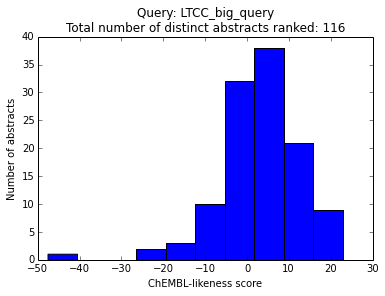

In [41]:
c.plot_scores([my_query_id1, my_query_id2], 'cluster_db', 'LTCC_big_query')